In [301]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa
import pathlib
import wandb
from wandb.keras import WandbCallback

In [302]:
print(tf.__version__)
print(tf.config.list_physical_devices("GPU"))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [303]:
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [304]:
DATA_DIR = pathlib.Path("augmented_dataset")
AUTOTUNE = tf.data.AUTOTUNE

CONFIG = dict(
    architecture="CNN",
    model_name="MobileNetV3Small",
    num_classes=2,
    img_height=224,
    img_width=224,
    epochs=400,
    learning_rate=1e-6,
    batch_size=32,
    dropout_rate=0.4,
    es_patience=20,
    valid_split=0.4,
    seed_value=42,
)

wandb.init(
    project="wssv-recognition",
    config=CONFIG,
    group="MobileNetV3Small",
    job_type="train",
)

In [306]:
image_count = len(list(DATA_DIR.glob("*/*.jpg")))
healthy_count = len(list(DATA_DIR.glob("healthy/*.jpg")))
wssv_count = len(list(DATA_DIR.glob("wssv/*.jpg")))

print(f"Total number of images: {image_count}")
print(f"Healthy: {healthy_count}")
print(f"WSSV: {wssv_count}\n")

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=CONFIG["valid_split"],
    subset="training",
    seed=CONFIG["seed_value"],
    image_size=(CONFIG["img_height"], CONFIG["img_width"]),
    batch_size=CONFIG["batch_size"],
)
print("")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=CONFIG["valid_split"],
    subset="validation",
    seed=CONFIG["seed_value"],
    image_size=(CONFIG["img_height"], CONFIG["img_width"]),
    batch_size=CONFIG["batch_size"],
)

class_names = train_dataset.class_names
print(f"\nClass names: {class_names}")

Total number of images: 930
Healthy: 702
WSSV: 228

Found 930 files belonging to 2 classes.
Using 558 files for training.

Found 930 files belonging to 2 classes.
Using 372 files for validation.

Class names: ['healthy', 'wssv']


In [307]:
validation_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(validation_batches // 5)
validation_dataset = validation_dataset.skip(validation_batches // 5)

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

print(
    f"\nNumber of training batches: {tf.data.experimental.cardinality(train_dataset)}"
)
print(
    "Number of validation batches: %d"
    % tf.data.experimental.cardinality(validation_dataset)
)
print("Number of test batches: %d" % tf.data.experimental.cardinality(test_dataset))


Number of training batches: 18
Number of validation batches: 10
Number of test batches: 2


In [308]:
"""
DEFINE BASE MODEL HERE
"""
base_model = tf.keras.applications.MobileNetV3Small(
    input_shape=(CONFIG["img_height"], CONFIG["img_width"], 3),
    include_top=False,
)

"""
CREATE MODEL HERE
"""
inputs = tf.keras.Input(shape=(CONFIG["img_height"], CONFIG["img_width"], 3))
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(rate=CONFIG["dropout_rate"], seed=CONFIG["seed_value"])(x)
outputs = tf.keras.layers.Dense(units=1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=CONFIG["learning_rate"]),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(thresholds=0, name="precision"),
        tf.keras.metrics.Recall(thresholds=0, name="recall"),
        tfa.metrics.F1Score(
            num_classes=1, average="weighted", name="f1_score", threshold=0.5
        ),
        tf.keras.metrics.FalseNegatives(name="fn"),
    ],
)

In [309]:
class_0_weight = (1 / healthy_count) * (image_count / 2.0)
class_1_weight = (1 / wssv_count) * (image_count / 2.0)
class_weight = {0: class_0_weight, 1: class_1_weight}

history = model.fit(
    train_dataset,
    epochs=CONFIG["epochs"],
    validation_data=validation_dataset,
    class_weight=class_weight,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=CONFIG["es_patience"]),
        WandbCallback(save_model=False),
    ],
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/400
17/18 [===========================>..] - ETA: 0s - loss: 0.9707 - accuracy: 0.7721 - precision: 0.3784 - recall: 0.1148 - f1_score: 0.0746 - fn: 117.0000

INFO:tensorflow:Assets written to: c:\Users\Enzo\Documents\GitHub\wssv-recognition\wandb\run-20230513_023001-7qnmpqwt\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Enzo\Documents\GitHub\wssv-recognition\wandb\run-20230513_023001-7qnmpqwt\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Enzo\Documents\GitHub\wssv-recognition\wandb\run-20230513_023001-7qnmpqwt\files\model-best)... Done. 0.0s


18/18 [==============================] - 26s 1s/step - loss: 0.9692 - accuracy: 0.7724 - precision: 0.3784 - recall: 0.1120 - f1_score: 0.0730 - fn: 120.0000 - val_loss: 0.6910 - val_accuracy: 0.7208 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_fn: 86.0000
Epoch 2/400
17/18 [===========================>..] - ETA: 0s - loss: 0.9241 - accuracy: 0.7592 - precision: 0.2000 - recall: 0.0750 - f1_score: 0.0150 - fn: 119.0000

INFO:tensorflow:Assets written to: c:\Users\Enzo\Documents\GitHub\wssv-recognition\wandb\run-20230513_023001-7qnmpqwt\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\Enzo\Documents\GitHub\wssv-recognition\wandb\run-20230513_023001-7qnmpqwt\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\Enzo\Documents\GitHub\wssv-recognition\wandb\run-20230513_023001-7qnmpqwt\files\model-best)... Done. 0.0s


18/18 [==============================] - 19s 1s/step - loss: 0.9341 - accuracy: 0.7563 - precision: 0.2128 - recall: 0.0800 - f1_score: 0.0286 - fn: 123.0000 - val_loss: 0.6627 - val_accuracy: 0.7240 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1_score: 0.0000e+00 - val_fn: 85.0000
Epoch 3/400
17/18 [===========================>..] - ETA: 0s - loss: 0.9543 - accuracy: 0.7629 - precision: 0.3529 - recall: 0.1440 - f1_score: 0.0584 - fn: 121.0000

KeyboardInterrupt: 

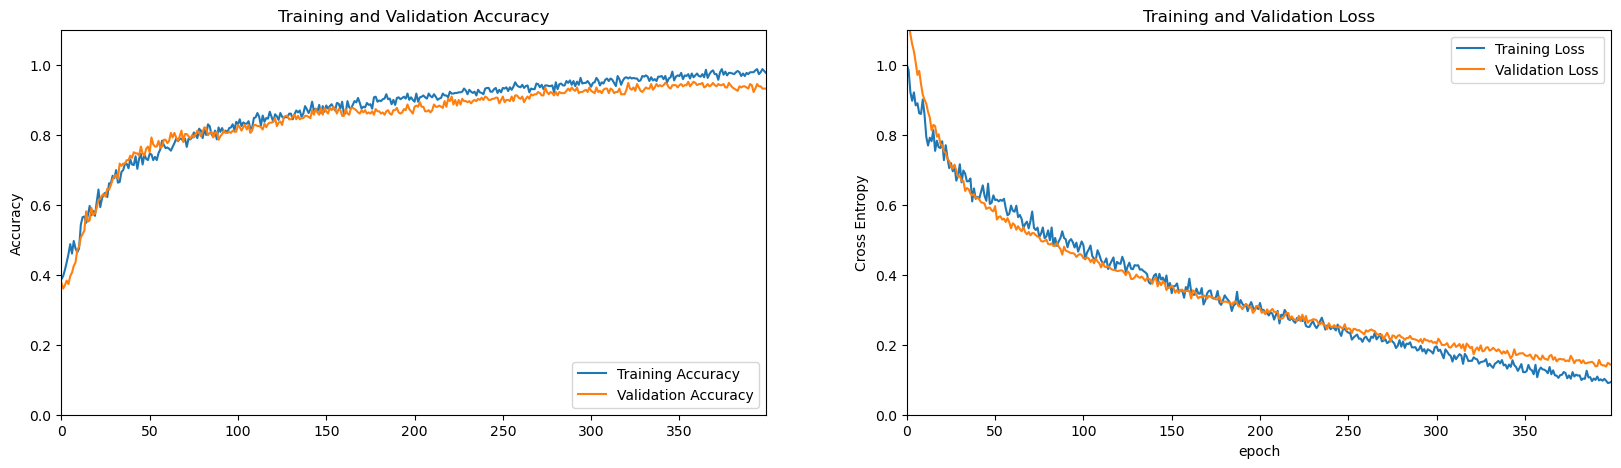

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

prec = history.history["precision"]
val_prec = history.history["val_precision"]

recall = history.history["recall"]
val_recall = history.history["val_recall"]

f1_score = history.history["f1_score"]
val_f1_score = history.history["val_f1_score"]

fns = history.history["fn"]
val_fns = history.history["val_fn"]


plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

NameError: name 'fns' is not defined

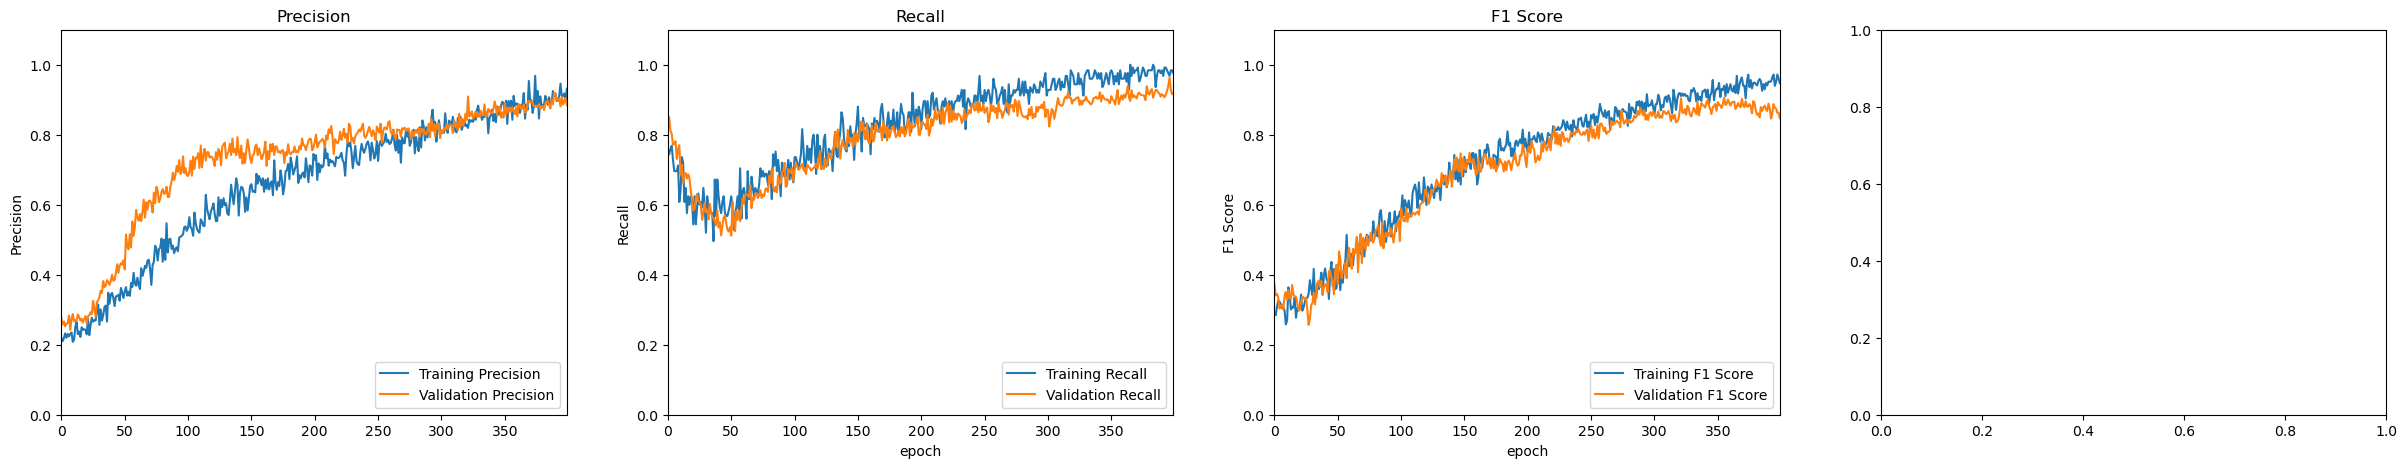

In [ ]:
plt.figure(figsize=(30, 5))
plt.subplot(1, 4, 1)
plt.plot(prec, label="Training Precision")
plt.plot(val_prec, label="Validation Precision")
plt.legend(loc="lower right")
plt.ylabel("Precision")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Precision")

plt.subplot(1, 4, 2)
plt.plot(recall, label="Training Recall")
plt.plot(val_recall, label="Validation Recall")
plt.legend(loc="lower right")
plt.ylabel("Recall")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("Recall")
plt.xlabel("epoch")

plt.subplot(1, 4, 3)
plt.plot(f1_score, label="Training F1 Score")
plt.plot(val_f1_score, label="Validation F1 Score")
plt.legend(loc="lower right")
plt.ylabel("F1 Score")
plt.ylim([0, 1.1])
plt.xlim([0, history.epoch[-1]])
plt.title("F1 Score")
plt.xlabel("epoch")

plt.subplot(1, 4, 4)
plt.plot(fns, label="Training False Negatives")
plt.plot(val_fns, label="Validation False Negatives")
plt.legend(loc="upper right")
plt.ylabel("False Negatives")
plt.ylim([0, 100])
plt.xlim([0, history.epoch[-1]])
plt.title("False Negatives")
plt.xlabel("epoch")

plt.show()

In [310]:
wandb.finish()